# FreezingPointTrend_Tiles_v1.py
Calculate the freezing point for each tile, and compare to the temperature trend to investigate the impact of freshening of the Arctic Ocean on Marine Heatwaves.

BR, 03/02/2023 

v1: Revamped for publication, 31/07/2023

In [1]:
import xarray as xr
import proplot as pplt
import numpy as np
import pandas as pd
import gsw as gsw
from pathlib import Path
import dask
pplt.rc['figure.facecolor'] = 'white'

In [2]:
from dask_jobqueue import SGECluster
from dask.distributed import Client

cluster = SGECluster(
    queue="compute",
    cores=30,          # Total number of cores per job
    processes=5,        # Cores/processes = threads/worker
    walltime="12:00:00",
    memory="250GB",    # Total amount of memory per job
    local_directory="~/Projects/SiberianHW/src/dask-worker-space/",
    scheduler_options={
        "dashboard_address": ":7880",
    },
)

cluster.scale(jobs=5)          # Number of workers
client = Client(cluster)    # Connect to that cluster
client

/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 7880 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43287 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SGECluster
Dashboard: /proxy/43287/status,
Dashboard: /proxy/43287/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://129.173.118.14:44673,Workers: 0
Dashboard: /proxy/43287/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Preprocessing
Define paths and load the tiled heat budgets and MLT.

In [3]:
# Path to data and figures
Path2Home = str(Path.home())
Path2proc = Path(Path2Home+"/Projects/SiberianHW/data/processed/")
Path2tiles = Path2proc.joinpath("tiles/")
Path2figs = Path(Path2Home+"/Projects/SiberianHW/figures/")
# Load MLD for tiles
ds_MLD = xr.open_dataset(Path2proc.joinpath('MLD_tiles_3Oceans.nc'))
# Load MLT for tiles
ds_MLT = xr.open_dataset(Path2proc.joinpath('MLT_tiles_3Oceans.nc'))
# Load MLSalt integration
ds_MLS = xr.open_dataset(Path2proc.joinpath('MLSalt_tiles_3Oceans.nc')).drop('month')
# Load Marine Heatwave detection
ds_clims = xr.open_dataset(Path2proc.joinpath("ClimThreshSmooth_MLT_Tiled3O.nc"))
ds_clims = ds_clims.assign_coords(time=('index',ds_MLS.time.data)).swap_dims({'index':'time'}).drop('index')
ds_mhws_filt = xr.open_dataset(Path2proc.joinpath('MHWfiltMean0.1_DetectionProperties_TiledMLT.nc'))
# Load Ice Properties for tiles
ds_Ice = xr.open_dataset(Path2proc.joinpath('IceProp_tiles_3Oceans.nc')).drop('month')
ds_Ice['fmmflx'] = ds_Ice.fmmflx  * 86400 # Convert from kg m-2 s-1 to kg m-2 day-1
ds_Ice.fmmflx.attrs['Units'] = "kg m$^{-2}$ d$^{-1}$"

## Calculate freezing point of sea water
Use the Gibbs SeaWater toolbox `gsw` which implements the TEOS-10 formulation for seawater. From it, can calculate the freezing point of seawater for each tile, using the salinity

In [4]:
# Calculate pressure at the middle of the MLD
ds_p = gsw.p_from_z(-ds_MLD.MLD/2,ds_MLD.latitude).rename('Pres')
# Use that pressure to calculate the freezing point. This could be arguable... Maybe surface would be more sensitive.
# Saturation fraction of 0.1, as per documentation.
T_freez = gsw.CT_freezing(ds_MLS.soce, ds_p, saturation_fraction=0.1)

##  Plot a specific tile
Make sure the calculation works and pre-analyse the results to make sure what we expect is there, and makes sense.

/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


Text(0.5, 0.98, 'Freezing point evolution')

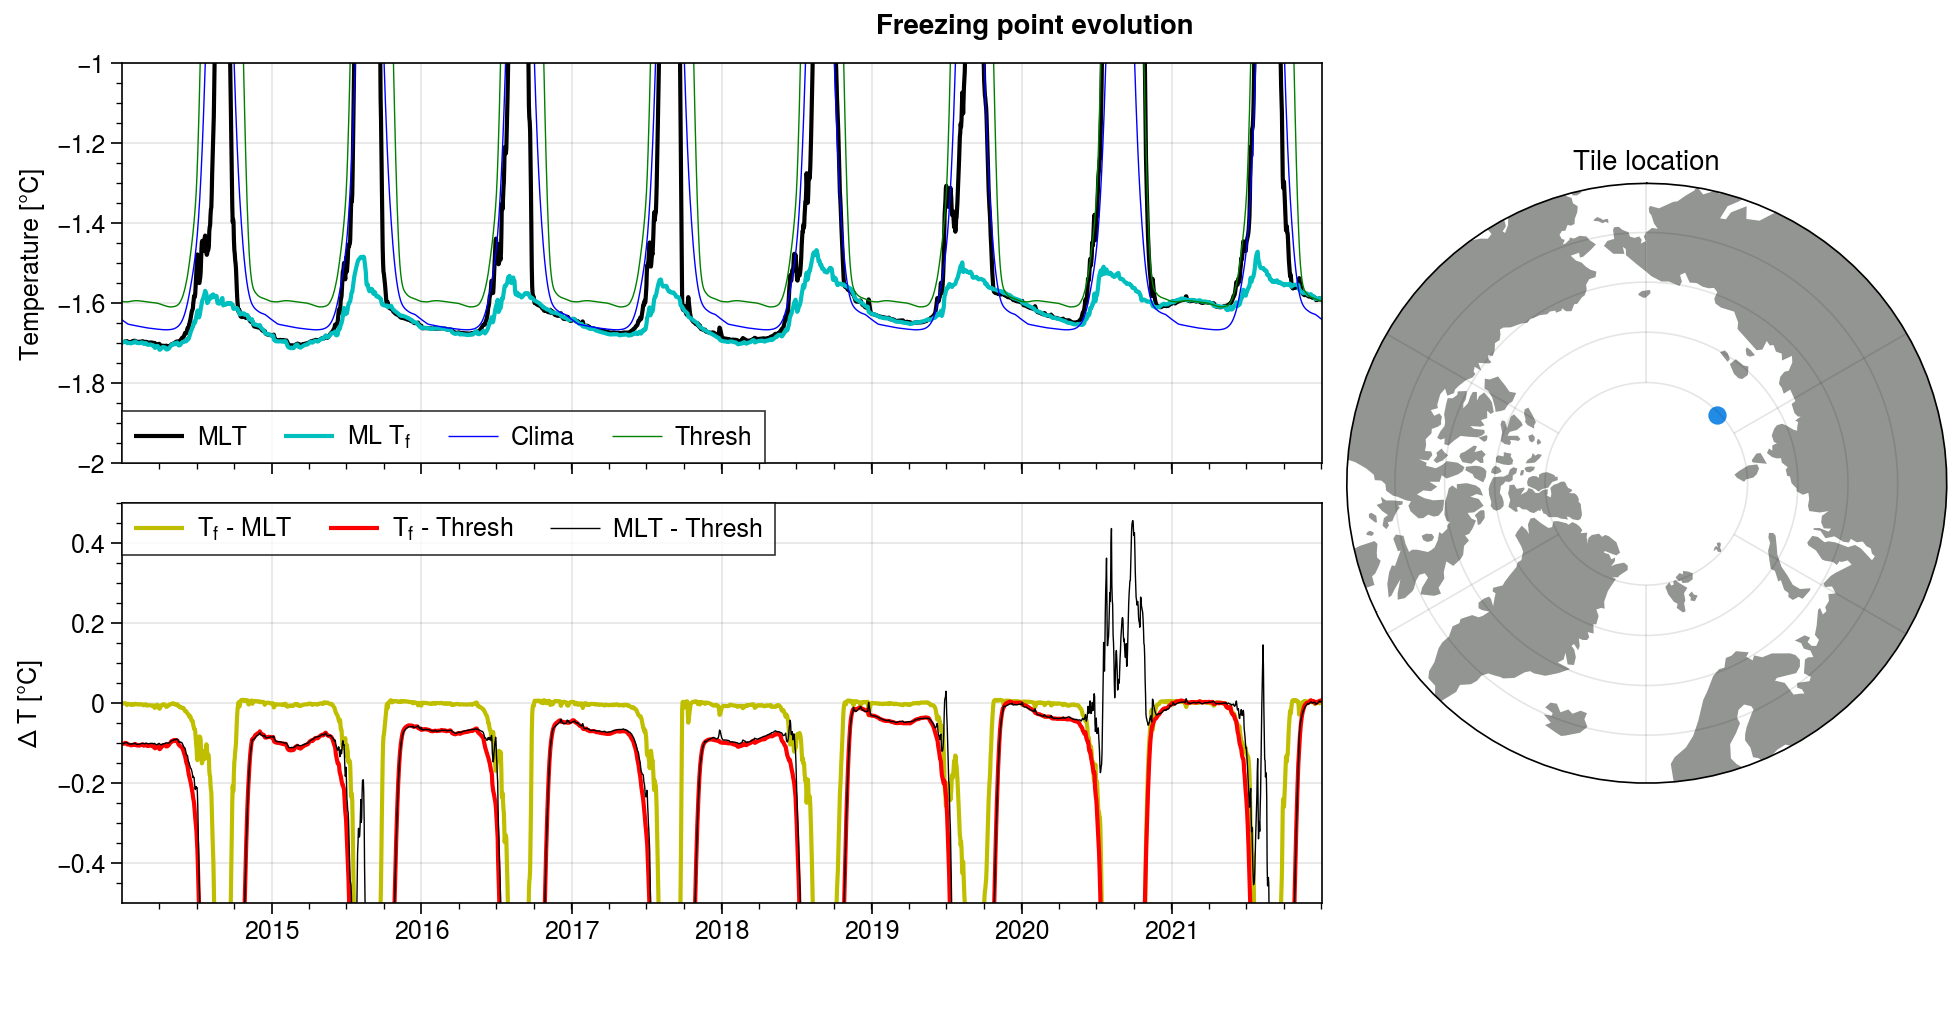

In [5]:
tt = 118 # Select a specific tile. Can play with that number.
# Plot
fig = pplt.figure(axwidth=6,axheight=2,sharey=0, sharex=3)
axs = fig.subplots([[1,1,0],[2,2,0]])
# First panel for ML Temperature, Freezing point, and MHW-related climatology and threshold.
axs[0].plot(ds_MLT.toce.isel(tiles=tt),c='k',label='MLT') # Mixed layer temperature
axs[0].plot(T_freez.isel(tiles=tt),c='c',label='ML T$_f$') # Mixed layer freezing point
axs[0].plot(ds_clims.seas.isel(tiles=tt),c='b',lw=0.5, label='Clima') # Mixed layer temperature climatology
axs[0].plot(ds_clims.thresh.isel(tiles=tt),c='g',lw=0.5, label='Thresh') # Mixed layer temperature 90th percentile.
axs[0].legend(ncol=4) # Add a legend
axs[0].format(ylabel='Temperature [°C]',
              ylim=[-2,-1.0]
             ) # Some formatting
# Second panel for the deviation of the ML Temperature and climatology from the freezing point
axs[1].plot((T_freez-ds_MLT.toce).isel(tiles=tt),c='y',label='T$_f$ - MLT') 
axs[1].plot((T_freez-ds_clims.thresh).isel(tiles=tt),c='r',label='T$_f$ - Thresh')
axs[1].plot((ds_MLT.toce-ds_clims.thresh).isel(tiles=tt),c='k',lw=0.5,label='MLT - Thresh') # Also diff between Temp and thresh
axs[1].legend()
axs[1].format(ylabel='$\Delta$ T [°C]',
              ylim=[-0.5,0.5]
             )
axs.format(xrotation=0)
# Third panel for a quick map of location of tile
proj=pplt.Proj('nplaea')
ax_end = fig.subplot(1,3,(3), projection=proj,)
ax_end.scatter(ds_MLT.isel(tiles=tt).longitude.values, 
               ds_MLT.isel(tiles=tt).latitude.values, 
               color='blue6')
ax_end.format(boundinglat=60, land=True, landcolor='grey', title='Tile location')
fig.suptitle("Freezing point evolution",)
# fig.save(Path2figs.joinpath("FreezingTempEvol_Pmld_tile{0:d}.png".format(ds_MLT.isel(tiles=tt).tiles)),dpi=400)

## Winter trend of freezing point
Calculate the trend of freezing point for March (maximum ice extent) or for JFM and plot that trend as a map.

In [6]:
T_nsyr = 31560685714285714 # Number of nanoseconds in a year. Needed to convert from datetime64 to reasonable units.
# Freezing-point March trend:
# COnvert from daily to monthly freezing point
T_freez_1m = T_freez.resample(time='1M').mean()
# Select month of March and drop the rest.
Freez_March = T_freez_1m.where(T_freez_1m['time.month']==3, drop=True)
# Then use the polyfit function to calculate a linear trend. 
# Need to multiply the trend by the number of nanoseconds between two time stamps to convert to reasonable units. Ugly...
Tf_Trend_March = Freez_March.polyfit(dim='time',deg=1).sel(degree=1, drop=True) * T_nsyr
# Mixed-layer Temperature trend: (same methodology)
MLT_1m = ds_MLT.toce.resample(time='1M').mean()
MLT_March = MLT_1m.where(MLT_1m['time.month']==3, drop=True)
# Then use the polyfit function to calculate a linear trend. 
MLT_Trend_March = MLT_March.polyfit(dim='time',deg=1).sel(degree=1, drop=True) * T_nsyr
# Add a calculation of salinity trend for March.
Salt_1m = ds_MLS.soce.resample(time='1M').mean()
Salt_March = Salt_1m.where(Salt_1m['time.month']==3,drop=True)
# Then use the polyfit function to calculate a linear trend. 
Salt_Trend_March = Salt_March.polyfit(dim='time',deg=1).sel(degree=1, drop=True) * T_nsyr

Now plot

/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


Text(0.5, 0.98, 'Trend, March')

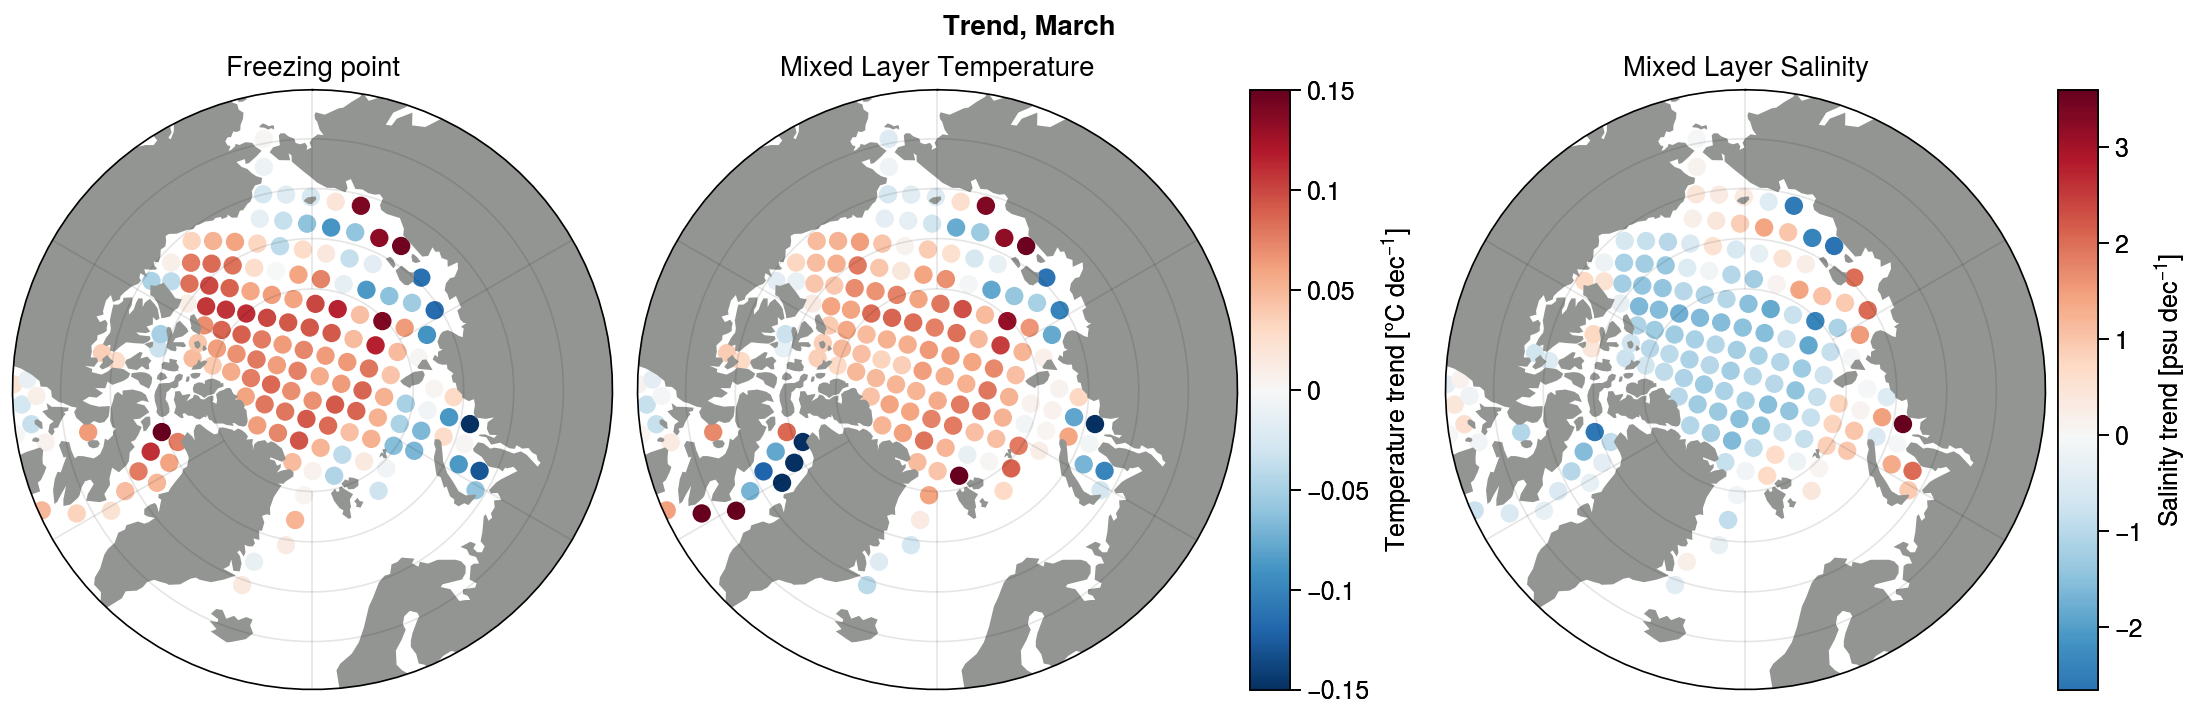

In [7]:
# Plot the slope of the trends as scatter map, with color corresponding to the slope.
fig, axs = pplt.subplots(ncols=3,axwidth=3,proj='nplaea')
# Freezing point trend
hsc = axs[0].scatter(ds_MLT.longitude.values, ds_MLT.latitude.values,
                     c=Tf_Trend_March.polyfit_coefficients*10,
                     vmin=-0.15, vmax=0.15
                    )
axs[0].format(title='Freezing point')
# Mixed layer temperature trend
hsc2 = axs[1].scatter(ds_MLT.longitude.values, ds_MLT.latitude.values,
                     c=MLT_Trend_March.polyfit_coefficients*10,
                     vmin=-0.15, vmax=0.15
                    )
axs[1].format(title='Mixed Layer Temperature')
# Mixed layer salinity trend
hsc3 = axs[2].scatter(ds_MLS.longitude.values, ds_MLS.latitude.values,
                     c=Salt_Trend_March.polyfit_coefficients*10,
                     # vmin=-0.15, vmax=0.15
                    )
axs[2].format(title='Mixed Layer Salinity')
# Some formatting
axs.format(boundinglat=60, land=True, landcolor='grey')
axs[1].colorbar([hsc],loc='r',label='Temperature trend [°C dec$^{-1}$]')
axs[2].colorbar([hsc3],loc='r',label='Salinity trend [psu dec$^{-1}$]')
fig.suptitle("Trend, March")

Same but for all 4 seasons

In [8]:
# Calculate seasonal trends
T_freez_seas = T_freez_1m.resample(time='QS').mean()
MLT_seas = MLT_1m.resample(time='QS').mean()
Tf_Trend = {}
MLT_Trend = {}
# Loop over seasons
for ii, seas in enumerate(np.arange(1,11,3)):
    Tf_Season = T_freez_seas.where(T_freez_seas.time.dt.month==seas,drop=True)
    Tf_Trend[ii] = Tf_Season.polyfit(dim='time',deg=1).sel(degree=1,drop=True)*T_nsyr
    MLT_Season = MLT_seas.where(MLT_seas.time.dt.month==seas,drop=True)
    MLT_Trend[ii] = MLT_Season.polyfit(dim='time',deg=1).sel(degree=1,drop=True)*T_nsyr

/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instant

Text(0.5, 0.98, 'Trend of Freezing Point, Seasonal')

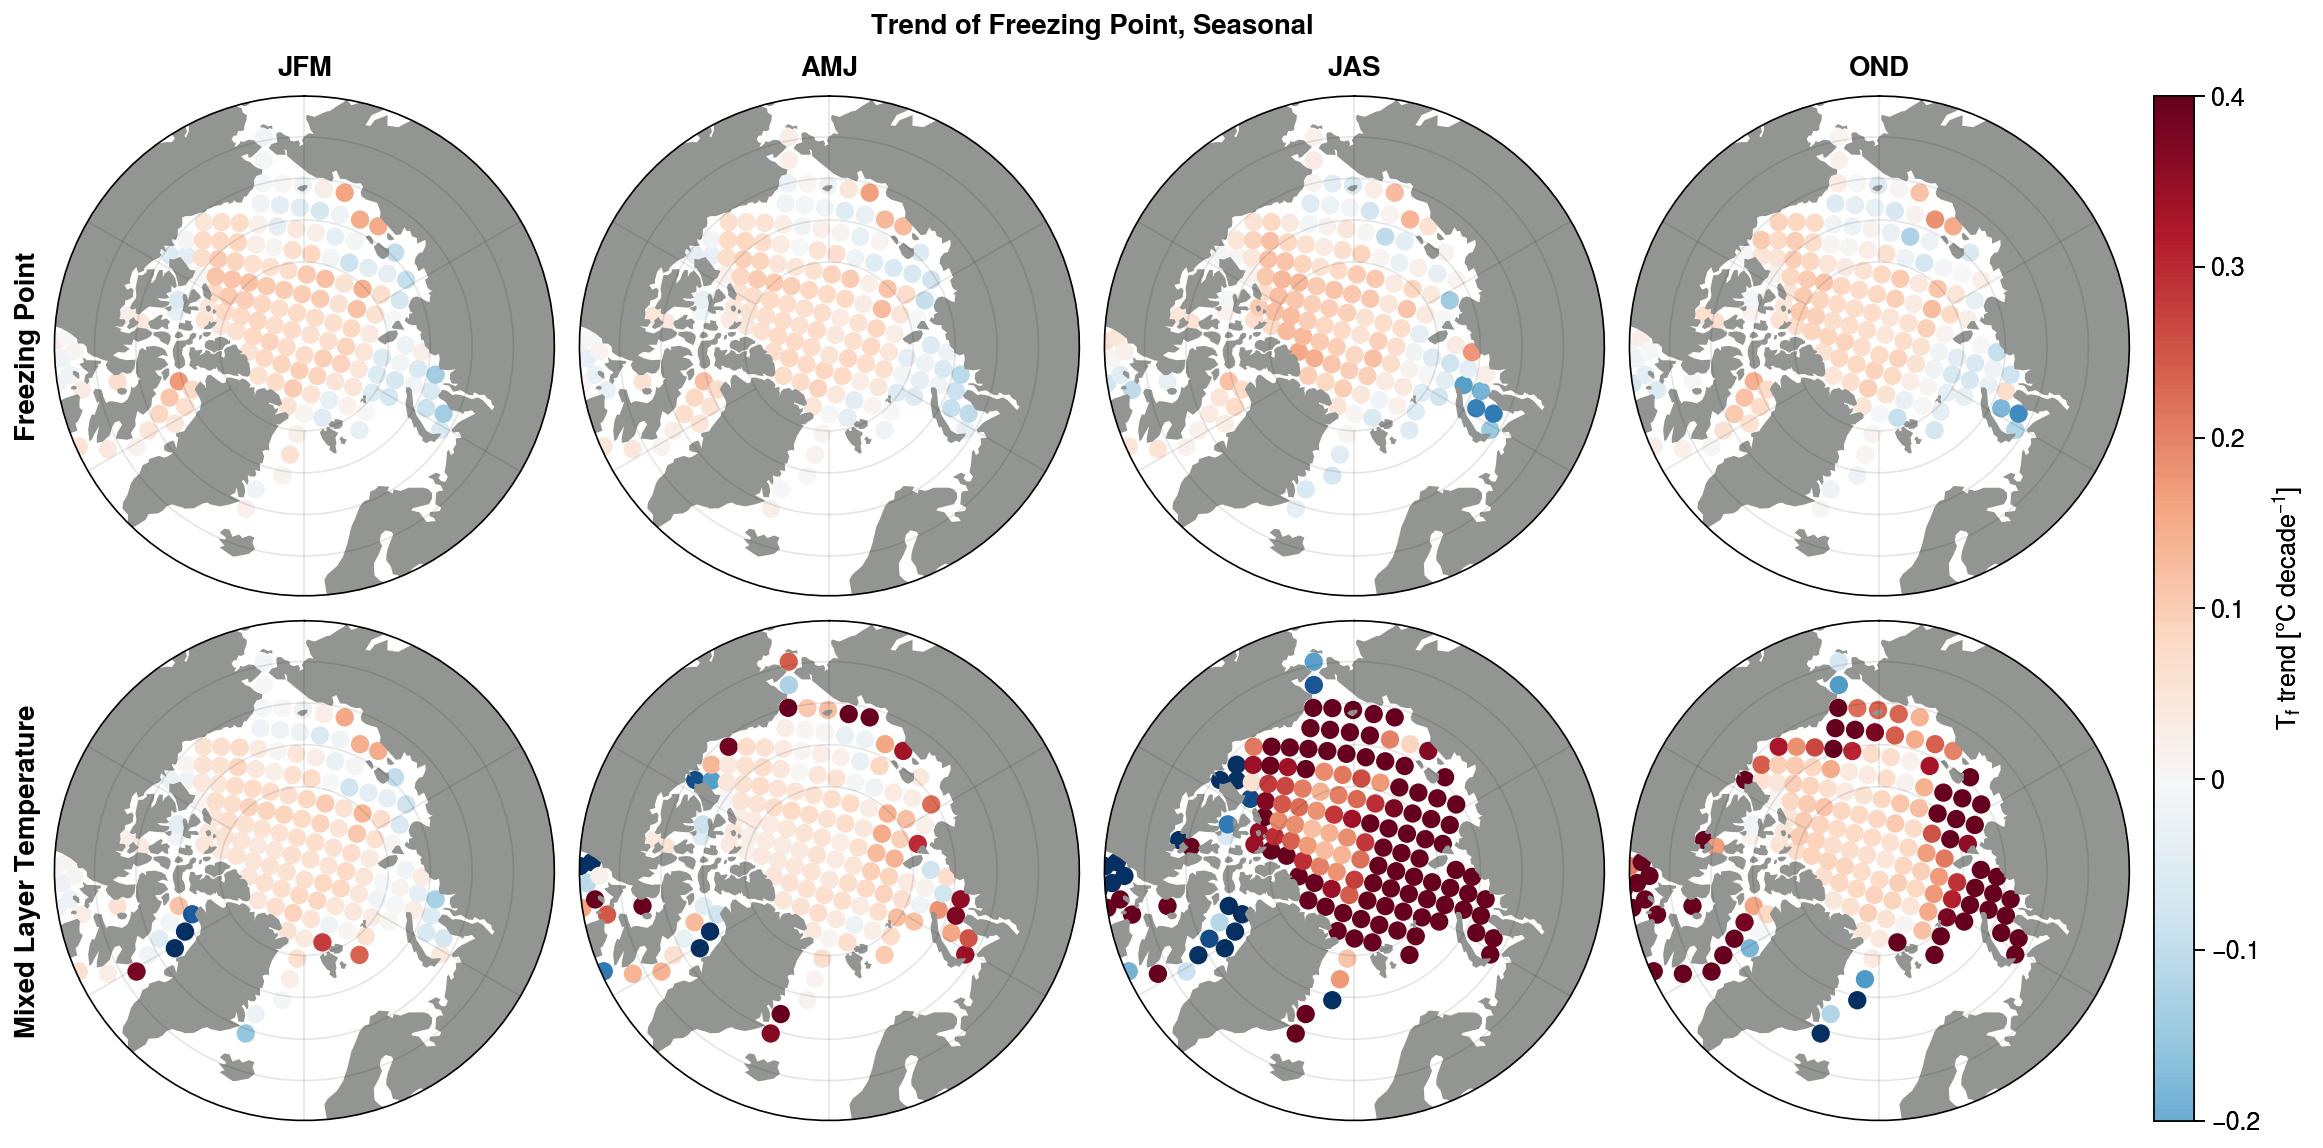

In [9]:
# Plot those seasonal trends    
fig, axs = pplt.subplots(nrows=2, ncols=4, proj='nplaea')
for ii, seas in enumerate(['JFM','AMJ','JAS','OND']):
    hsc = axs[ii].scatter(ds_MLT.longitude.values, ds_MLT.latitude.values, 
                          c=Tf_Trend[ii].polyfit_coefficients * 10,
                          vmin=-0.2, vmax = 0.4,
                         )
for ii, seas in enumerate(['JFM','AMJ','JAS','OND']):
    hsc = axs[ii+4].scatter(ds_MLT.longitude.values, ds_MLT.latitude.values, 
                          c=MLT_Trend[ii].polyfit_coefficients * 10,
                          vmin=-0.2, vmax = 0.4,
                         )
axs.format(boundinglat=60, land=True, landcolor='grey',
           toplabels = ['JFM','AMJ','JAS','OND'],
           leftlabels = ['Freezing Point','Mixed Layer Temperature']
          )
fig.colorbar(hsc,loc='r',label='T$_f$ trend [°C decade$^{-1}$]')
fig.suptitle("Trend of Freezing Point, Seasonal")
# fig.save(Path2figs.joinpath("SeasonalTrend_FreezingPoint_Tiles3Oceans.png"),dpi=400)

## Publication plot
Try to generate a plot that would fit the paper: map(s?) of the trends in winter and 1-2 panels to show a time series

/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


Text(0.5, 0.98, 'Freshening-Induced Winter Temperature Trend')

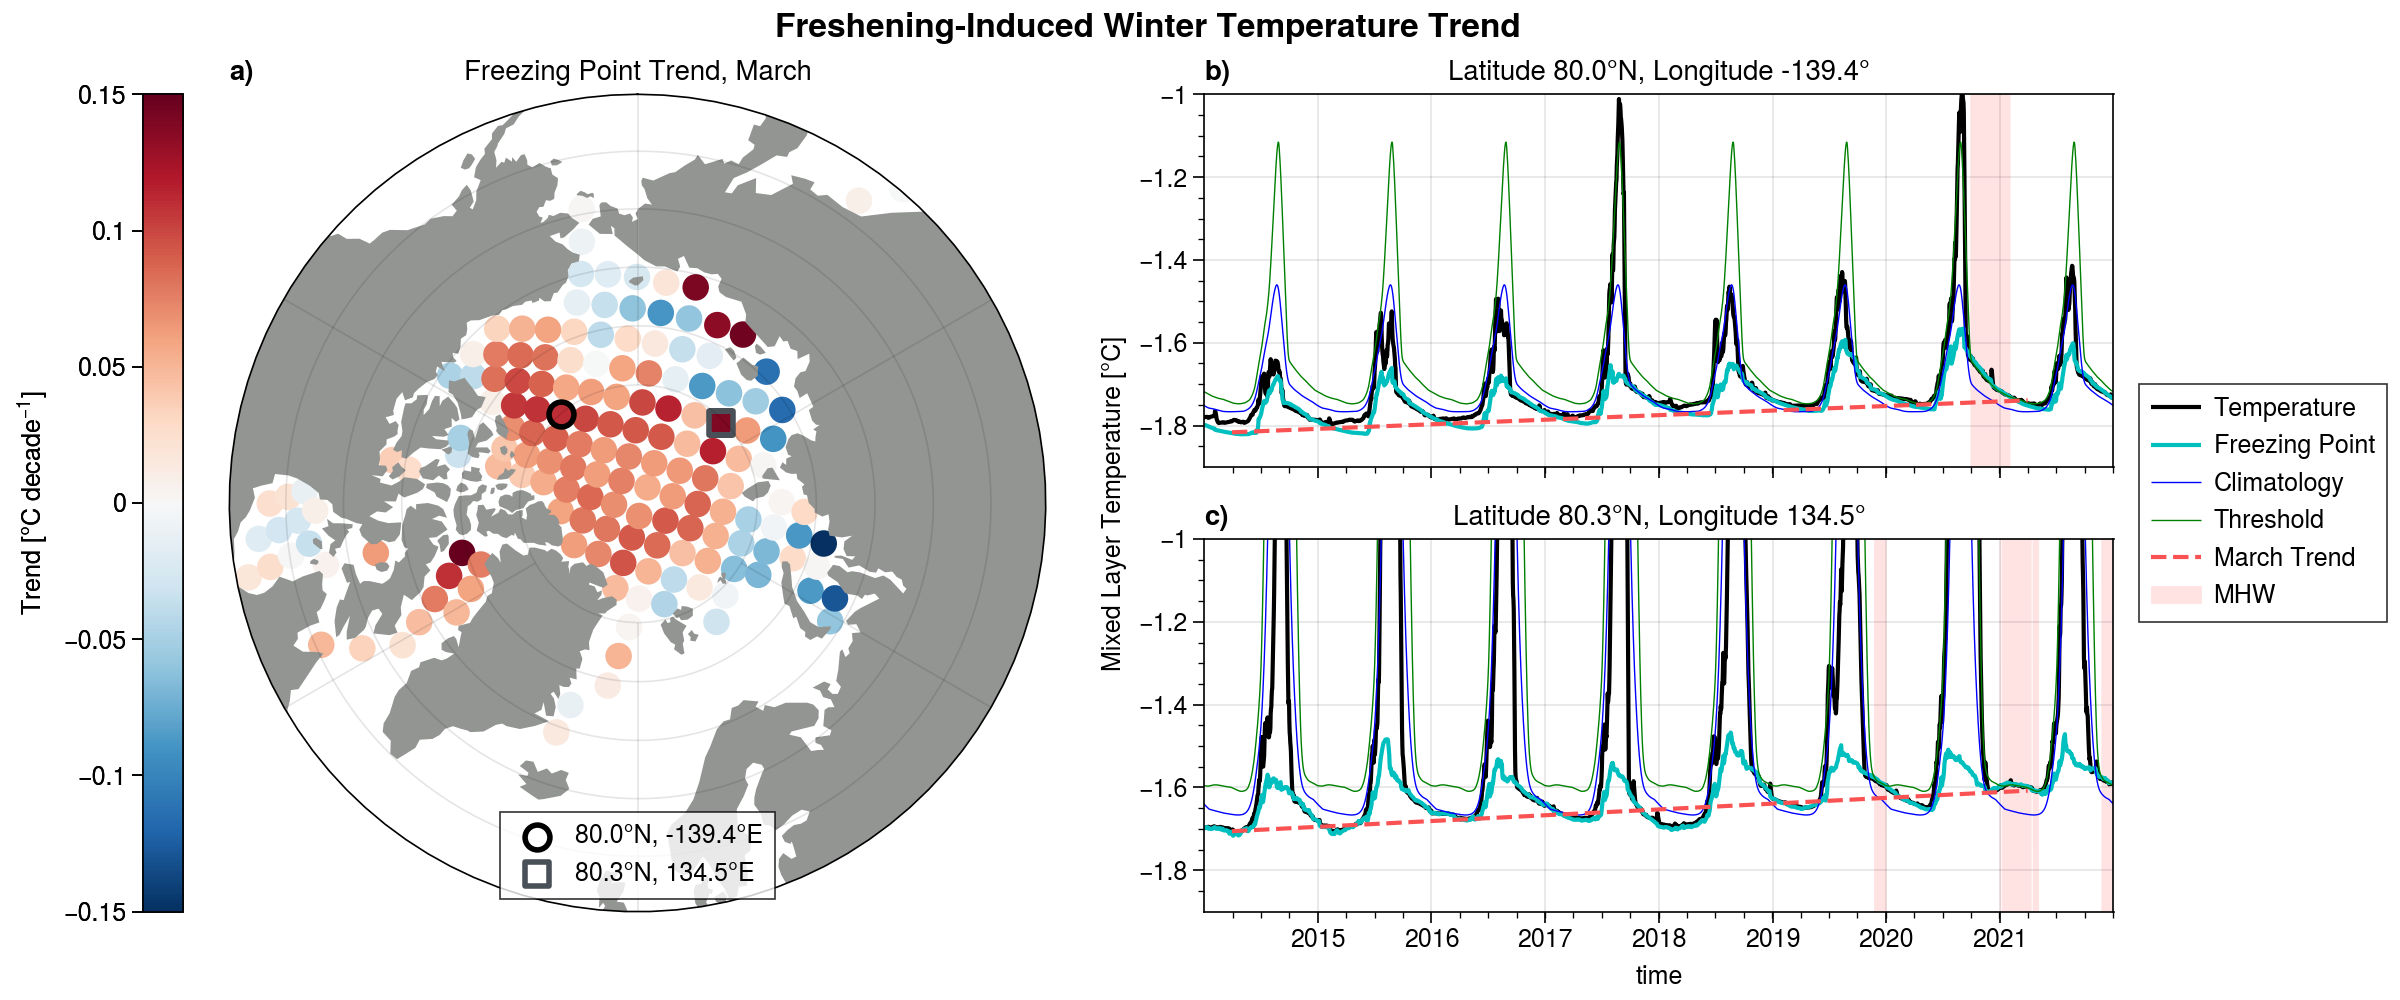

In [10]:
# Select two different tiles that would illustrate different behaviours. Get their coordinates
tt1, tt2 = 98, 118
Lat1,Lon1 = ds_MLT.isel(tiles=tt1).latitude.values, ds_MLT.isel(tiles=tt1).longitude.values
Lat2,Lon2 = ds_MLT.isel(tiles=tt2).latitude.values, ds_MLT.isel(tiles=tt2).longitude.values
# Rebuild their linear trends using slope and initial value, to plot
Trend_tt1 = np.arange(0,Freez_March.time.size)*Tf_Trend_March.polyfit_coefficients.isel(tiles=tt1).values \
            + Freez_March.isel(tiles=tt1,time=0).values
Trend_tt2 = np.arange(0,Freez_March.time.size)*Tf_Trend_March.polyfit_coefficients.isel(tiles=tt2).values \
            + Freez_March.isel(tiles=tt2,time=0).values
# Now plot the results
fig = pplt.figure(width=12,height=5,sharey=1, sharex=3)
axs = fig.subplots([[1,2],[1,3]],abc='a)')
# First tile: plot the ML Temp, freezing point, MLT clim and thresh, calculated trend, and add period of "freezing" MHW
axs[1].plot(ds_MLT.toce.isel(tiles=tt1),c='k',label='Temperature')
axs[1].plot(T_freez.isel(tiles=tt1),c='c',label='ML T$_f$')
axs[1].plot(ds_clims.seas.isel(tiles=tt1),c='b',lw=0.5, label='Clima')
axs[1].plot(ds_clims.thresh.isel(tiles=tt1),c='g',lw=0.5, label='Thresh')
axs[1].plot(Freez_March.time,Trend_tt1,c='red6',ls='--')
axs[1].area((T_freez.isel(tiles=tt1) >= ds_clims.thresh.isel(tiles=tt1))*(-3),color='red1')
axs[1].format(ylabel='Mixed Layer Temperature [°C]',ylim=[-1.9,-1.0],
              title='Latitude {0:.1f}°N, Longitude {1:.1f}°'.format(Lat1,Lon1)
             )
# Second tile: plot the ML Temp, freezing point, MLT clim and thresh, calculated trend, and add period of "freezing" MHW
h0 = axs[2].plot(ds_MLT.toce.isel(tiles=tt2),c='k',label='Temperature')
h1 = axs[2].plot(T_freez.isel(tiles=tt2),c='c',label='Freezing Point')
h2 = axs[2].plot(ds_clims.seas.isel(tiles=tt2),c='b',lw=0.5, label='Climatology')
h3 = axs[2].plot(ds_clims.thresh.isel(tiles=tt2),c='g',lw=0.5, label='Threshold')
h4 = axs[2].plot(Freez_March.time,Trend_tt2,c='red6',ls='--',label='March Trend')
h5 = axs[2].area((T_freez.isel(tiles=tt2) >= ds_clims.thresh.isel(tiles=tt2))*(-3),color='red1',label='MHW')
axs[2].format(xrotation=0,ylabel='Temperature [°C]',ylim=[-1.9,-1.0],
              title='Latitude {0:.1f}°N, Longitude {1:.1f}°'.format(Lat2,Lon2)
             )
fig.legend([h0,h1,h2,h3,h4,h5],ncol=1)

# Scatter map covering the Arctic.
# Each dot shows a tile, its color shows the slope of the freezing point trend
proj=pplt.Proj('nplaea')
axs[0].set_visible(False)
ax_end = fig.subplot(1,2,(1), projection=proj,abc='a)',number=1)
hsc = ax_end.scatter(ds_MLT.longitude.values, ds_MLT.latitude.values,
                     c=Tf_Trend_March.polyfit_coefficients*10,
                     vmin=-0.15, vmax=0.15,
                     s=80,
                     # colorbar='b', colorbar_kw={'label':'Trend [°C decade$^{-1}$]'}
                    )
# Add markers for tile 1 and 2. Will need to add arrows connecting to panel manually using Gimp.
hsc1 = ax_end.scatter(Lon1,Lat1,edgecolors='k',lw=2,facecolors='none', 
                      s=80, m='o', label='{0:.1f}°N, {1:.1f}°E'.format(Lat1,Lon1))
hsc2 = ax_end.scatter(Lon2,Lat2,edgecolors='grey7',lw=2,facecolors='none', 
                      s=80, m='s', label='{0:.1f}°N, {1:.1f}°E'.format(Lat2,Lon2))
# Some formatting.
ax_end.legend([hsc1,hsc2],ncol=1,loc='b',space=-4)
ax_end.colorbar(hsc,loc='l',label='Trend [°C decade$^{-1}$]')
ax_end.format(boundinglat=55, land=True, landcolor='grey', title='Freezing Point Trend, March')
fig.suptitle("Freshening-Induced Winter Temperature Trend",fontsize=12)
# fig.save(Path2figs.joinpath("LineScatterMap_FreezingTempTrend_2tiles.png"),dpi=400)
# fig.save(Path2figs.joinpath("LineScatterMap_FreezingTempTrend_2tiles.svg"))

## Compare Winter MLT trend with salinity-induced freezing trend
Try to quantify how much of the winter temperature trend is due to the freezing point trend. To do so, calculate some form of percentage.

/home/brichaud/.conda/envs/SibHW_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


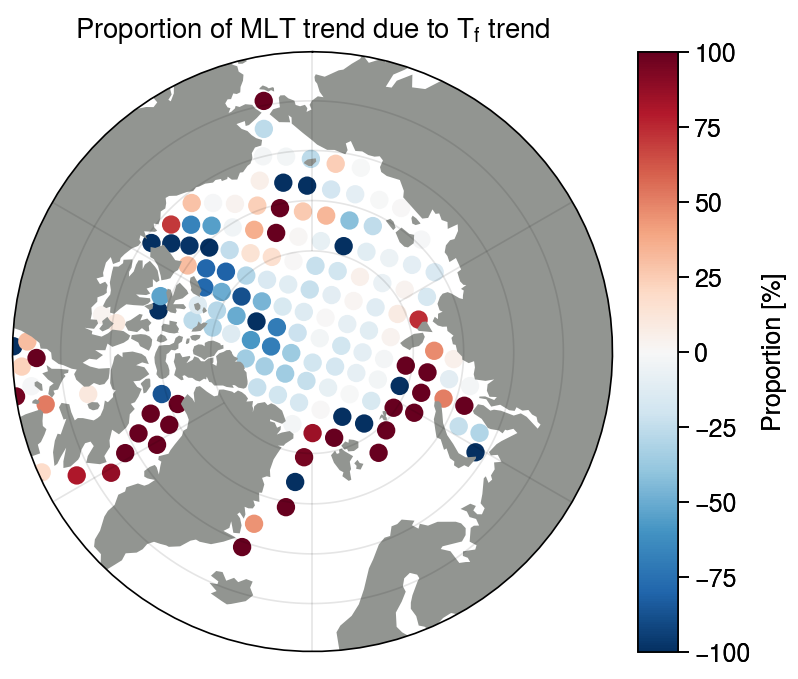

In [11]:
# Get difference between freezing point trend and actual trend.
DiffMarchTrends = MLT_Trend_March - Tf_Trend_March
# Divide by actual trend to get how much of the trend is explained by the freezing point only.
Trend_Due2Tf = DiffMarchTrends / MLT_Trend_March
# Plot
fig, axs = pplt.subplots(ncols=1,axwidth=3,proj='nplaea')
hsc = axs[0].scatter(ds_MLT.longitude.values, ds_MLT.latitude.values,
                     c=Trend_Due2Tf.polyfit_coefficients*100,
                     vmin=-100, vmax=100
                    )
axs[0].format(title='Proportion of MLT trend due to $T_f$ trend')
axs.format(boundinglat=60, land=True, landcolor='grey')
fig.colorbar([hsc],loc='r',label='Proportion [%]')
# fig.suptitle("")